In [48]:
# Todas las funciones aquí definidas y utilizadas están escritas en un .py con objetivo de poder ser usadas en el resto de NoteBooks.

In [35]:
import os
import cv2 as cv
import PIL
import numpy as np
import matplotlib.pyplot as plt
import re
plt.rcParams["figure.figsize"] = (30,30)

# Lo primero que hemos de hacer es automatizar el proceso de recortar en cuadrados las imágenes de heridas y de los tejidos sanos de la misma imagen.

def cut(path_load, name):
    import numpy as np
    import cv2 as cv

    img = cv.imread(path_load+"/"+name)

    # Guardamos las dimensiones de la imagen
    dims = (img.shape[0], img.shape[1])

    # Vamos a realizar una suma en los 3 canales RBG, por lo que tendremos un array de Width x Height.
    img_sum = np.sum(img, axis = 2)

    # Ahora trataremos de encontrar el píxel mínimo y máximo en cada dimensión diferente de cero.
    indexs = [[],[]]

    [indexs[0], indexs[1]] = [[np.where(img_sum[i,:]>0) for i in range(dims[0])], [np.where(img_sum[:,i]>0) for i in range(dims[1])]]

    # En indexs[0] tenemos 480 arrays con los indices de los píxeles que son mayores de cero para la primera dimensión. De forma análoga para indexs[1].

    min_x = [indexs[1][i][0][0] if len(indexs[1][i][0] > 0) else -1 for i in range(len(indexs[1]))]
    max_x = [indexs[1][i][0][len(indexs[1][i][0])-1] if len(indexs[1][i][0] > 0) else -1 for i in range(len(indexs[1]))]

    min_x = np.min(list(filter(lambda number: number > 0, min_x)))
    max_x = np.max(list(filter(lambda number: number > 0, max_x)))

    limits_x = (min_x, max_x)

    min_y = [indexs[0][i][0][0] if len(indexs[0][i][0] > 0) else -1 for i in range(len(indexs[0]))]
    max_y = [indexs[0][i][0][len(indexs[0][i][0])-1] if len(indexs[0][i][0] > 0) else -1 for i in range(len(indexs[0]))]

    min_y = np.min(list(filter(lambda number: number > 0, min_y)))
    max_y = np.max(list(filter(lambda number: number > 0, max_y)))

    limits_y = (min_y, max_y)

    new_dims = np.max([limits_x[1]-limits_x[0], limits_y[1]-limits_y[0]])

    # Ahora hemos de recortar la imagen.

    new_limits = [(limits_x[0],limits_y[0]),(limits_x[0]+new_dims, limits_y[0]+new_dims)]

    img_new = img[new_limits[0][0]:new_limits[1][0],new_limits[0][1]:new_limits[1][1],:]

    # Si la imagen no es un cuadrado la rellenaremos con píxeles en negro.

    if img_new.shape[0] != img_new.shape[1]:
        index_min = np.where(np.array([img_new.shape[0], img_new.shape[1]]) == np.min(np.array([img_new.shape[0], img_new.shape[1]])))[0][0]
        if index_min == 0:
            zeros = np.zeros((img_new.shape[1]-img_new.shape[0],img_new.shape[1],3))
            new_img = np.vstack((zeros, img_new))
            return new_img
        else:
            zeros = np.zeros((img_new.shape[0],img_new.shape[0]-img_new.shape[1],3))
            new_img = np.hstack((zeros, img_new))
            return new_img
    else:
        return img_new

In [36]:
# Función de preprocesado: normalización de 0-255 a 0-1 y posterior estandarización de los 3 canales RGB independientemente.
# Para realizar la estandarización hemos de usar la media y la std de las imágenes de tejido sano correspondientes a cada una de las heridas orales.
# Devuelve una imagen.

def preprocessing(path_inj, path_healthy, name_img, format):
    import numpy as np
    import cv2 as cv

    img_inj = cv.imread(path_inj+"/"+name_img+"."+format)
    img_healthy = cv.imread(path_healthy+"/"+name_img+"."+format)

    def standardize(img1, img2):
        mean = np.mean(img1)
        std = np.std(img1)
        img = (img2-mean)/std
        return img

    r_channel = standardize(img_healthy[:,:,0], img_inj[:,:,0])
    g_channel = standardize(img_healthy[:,:,1], img_inj[:,:,1])
    b_channel = standardize(img_healthy[:,:,2], img_inj[:,:,2])

    # Para evitar valores negativos en las imágenes de salida, aplicaremos la "unity-based normalization" tras estandarizar los canales.

    image_std = np.stack([r_channel, g_channel, b_channel], axis=-1)
    image_std_normalized = (image_std-np.min(image_std))/(np.max(image_std)-np.min(image_std))

    return image_std_normalized

In [37]:
# Función de redimensión de una imagen a otro tamaño destino. Toma como entrada una imagen y las dimensiones deseadas.
# Como entrada también toma el tipo de interpolación deseada para redimensionar la imagne.
# Devuelve una imagen.

def resize(img, X, Y, method = "linear"):
    import cv2 as cv
    if method == "linear":
        res = cv.resize(img, (X,Y), interpolation=cv.INTER_LINEAR)
    elif method == "nearest":
        res = cv.resize(img, (X,Y), interpolation=cv.INTER_NEAREST)
    elif method == "area":
        res = cv.resize(img, (X,Y), interpolation=cv.INTER_AREA)
    elif method == "cubic":
        res = cv.resize(img, (X,Y), interpolation=cv.INTER_CUBIC)
    elif method == "lanczos4":
        res = cv.resize(img, (X,Y), interpolation=cv.INTER_LANCZOS4)
    else:
        print("Please choose one of the available interpolation methods: 'linear', 'nearest', 'area', 'cubic' or 'lanczos4'. Linear interpolation works by default.")
    
    return res

In [38]:
# Función para mostrar una lista de imágenes.

def plot_img(images, rows, cols):
    import matplotlib.pyplot as plt
    if len(images.shape)>3:
        for i in range(images.shape[0]):
            img = images[i]
            plt.subplot(rows,cols,i+1)
            plt.rcParams["figure.figsize"] = (9,9)
            plt.axis('off')
            plt.imshow(img)
    else:
        img = images
        plt.rcParams["figure.figsize"] = (9,9)
        plt.axis('off')
        plt.imshow(img)

In [39]:
# Función para guardar de forma que se visualice. Es idéntica a la función de mostrar imagen con la única diferencia de que, además, guarda la imagen.
# La imagen se guarda únicamente con el objetivo de visualizarla fuera de Python, pero ni el tamaño coincide ni los píxeles son los mismos tras volverla a cargar en Python.

def save_img(img, path_save, name, format):
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (9,9)
    plt.axis('off')
    plt.imshow(img)
    plt.savefig(path_save+"/"+name+"."+format)

In [40]:
# Lo primero que haremos será cargar las imágenes de las heridas y las zonas sanas, recortarlas y guardarlas en otra carpeta.

files1 = os.listdir("Heridas/Originales")
files2 = os.listdir("Sanos/Originales")

for i in range(len(files1)):
    img1 = cut(path_load = "Heridas/Originales", name = files1[i])
    img2 = cut(path_load = "Sanos/Originales", name = files2[i])
    cv.imwrite("Heridas/Recortados/"+re.findall(r'\d+', files1[i])[0]+".png", img1)
    cv.imwrite("Sanos/Recortados/"+re.findall(r'\d+', files2[i])[0]+".png", img2)

In [41]:
# Ahora hemos de tener en cuenta que las imágenes van a tener diferente tamaño tras estandarizarlas y normalizarlas, por lo que será necesario hacer un redimensionado
# a algunas de ellas para que todas tengan la misma dimensión. No obstante, ya tenemos las imágenes en cuadrados. Guardaremos también los tamaños.

import os

files = os.listdir("Heridas/Recortados")

processed_images, sizes = [preprocessing(path_inj = "Heridas/Recortados", path_healthy = "Sanos/Recortados", name_img = str(i+1), format = "png") for i in range(len(files))], [preprocessing(path_inj = "Heridas/Recortados", path_healthy = "Sanos/Recortados", name_img = str(i+1), format = "png").shape[0] for i in range(len(files))]

In [42]:
# Redimensionaremos las imágenes mediante el método de interpolación linear.
# Para la redimensión sería conveniente utilizar una media de las dimensiones.

new_dim = int(round(np.mean(sizes)))

resized_images = [resize(processed_images[i], X = new_dim, Y = new_dim, method = "linear") for i in range(len(files))]

# Por último las vamos a disponer en un array todas juntas.
resized_images = np.stack(resized_images, axis = 0)

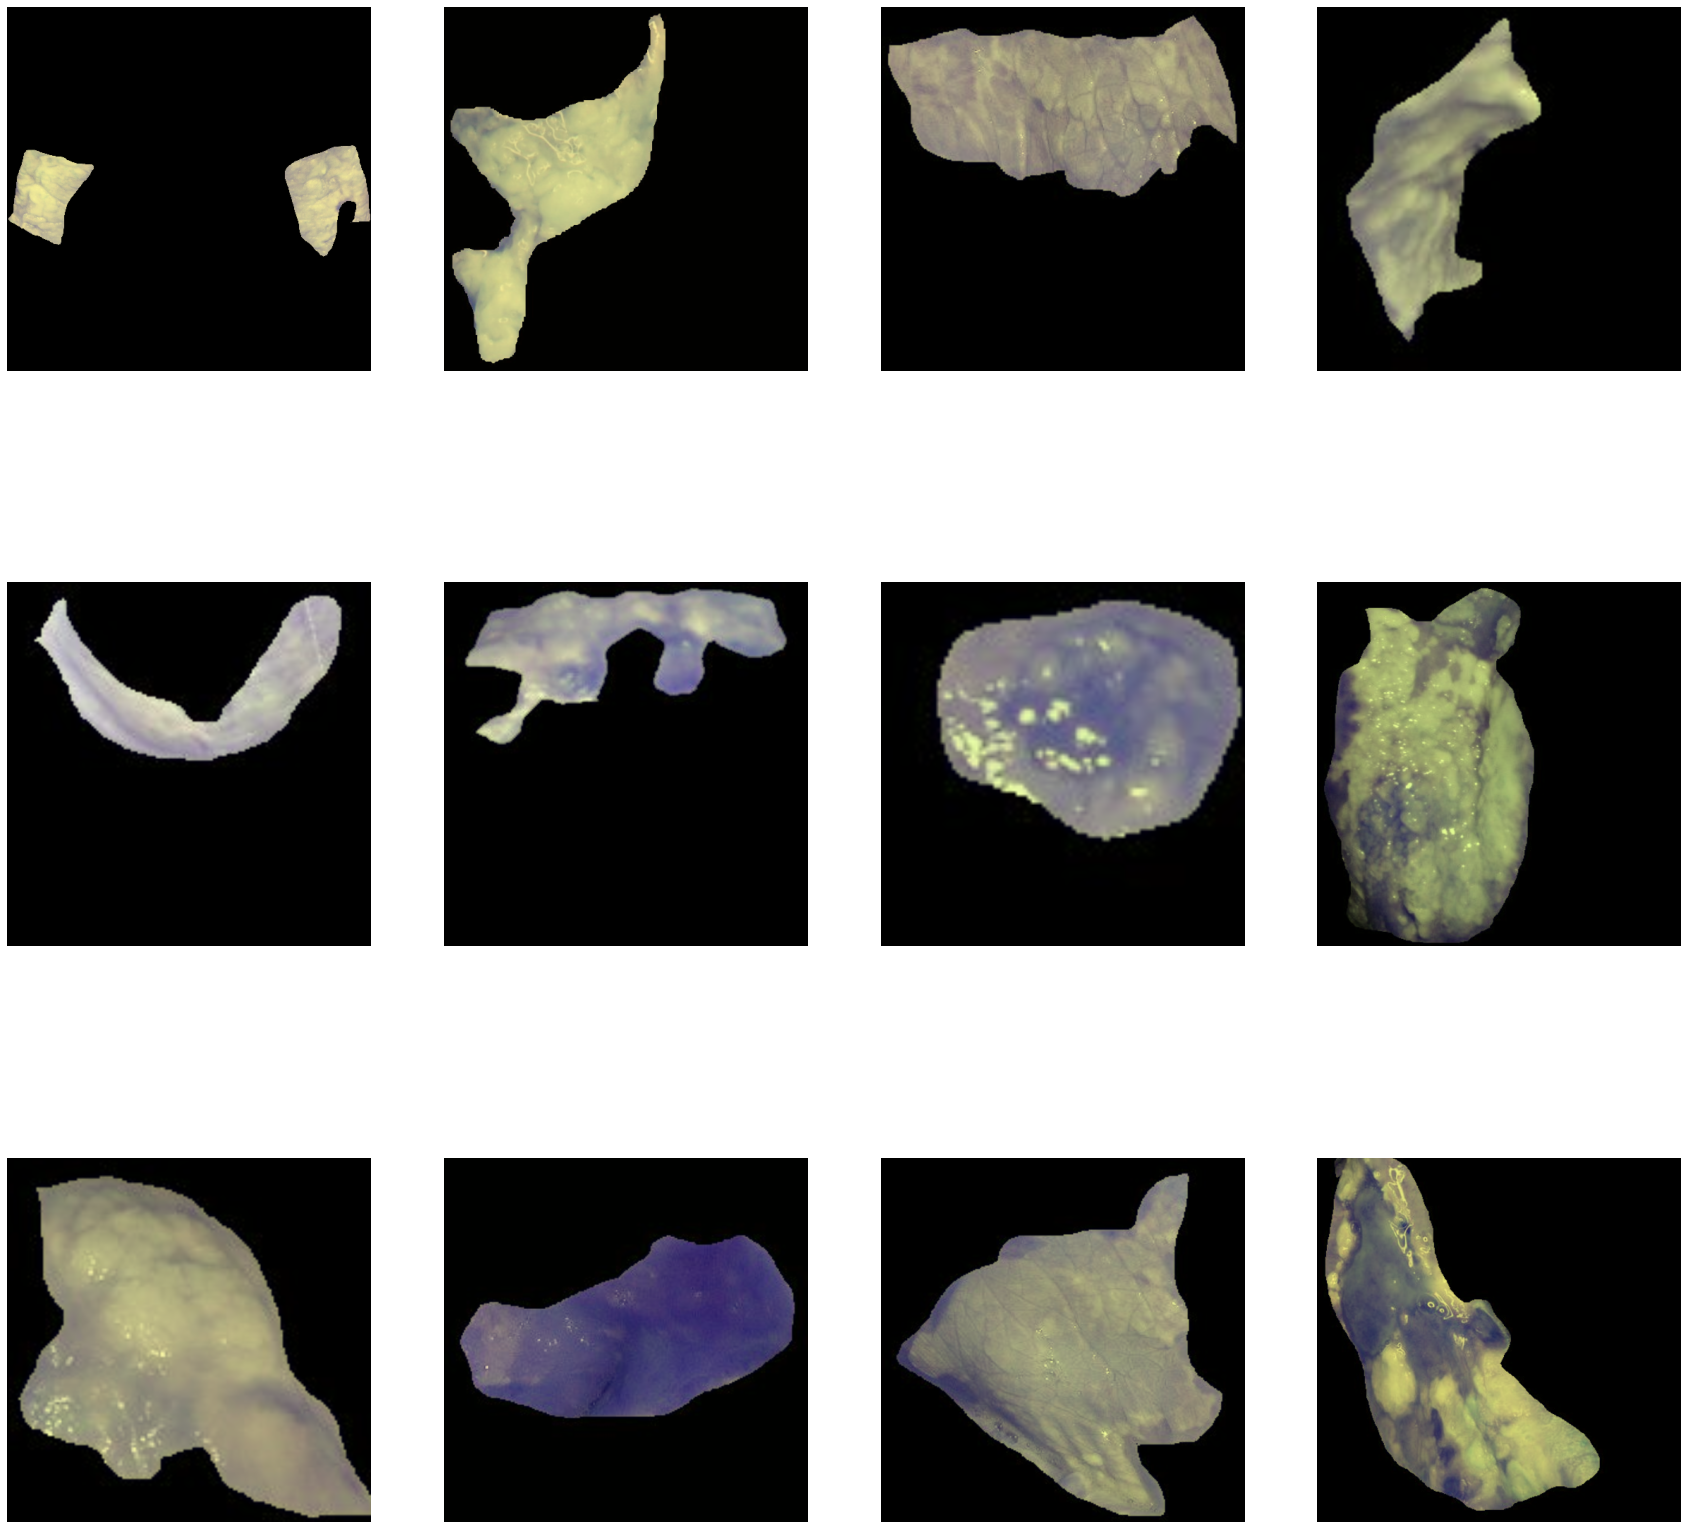

In [43]:
# Ploteamos las imágenes procesadas.

plot_img(resized_images, rows = 3, cols = 4)

In [47]:
# A continuación guardaremos 'resized_images' en un archivo h5 para posterior uso.

import h5py

hf = h5py.File("processed.h5", "w")
hf.create_dataset("processed_images", data = resized_images)
hf.close()